# Modélisation avec Random Forest

In [ ]:
conda install python-graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import fonctions as f

#Bibliothèques pour la visualisation des arbres
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import pandas as pd



In [2]:
#on divise la base en partie test et en partie entraînement
data= f.pd.read_csv("dataMod.csv", index_col =["DATE"])
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# On divisie la base train en une partie contenant les variables explicatives et la variable d'interêt
x_train=train.drop('TM',axis=1)
TM_train=train['TM']
# On divisie la base test en une partie contenant les variables explicatives et la variable d'interêt
x_test=test.drop('TM',axis=1)
TM_test=test['TM']

In [3]:
#recherche des meilleurs paramètres 
param_dist = {'n_estimators': randint(50,500),# il s’agit du nombre d’arbres dans la forêt
              'max_depth': randint(1,20)}#il s’agit de la profondeur maximale des arbres utilisés (le nombre de niveaux dans l’arbre de décision)

# Creation d'un random forest classifier
rf = RandomForestRegressor()

# Utilisation de random search pour trouver les meilleurs paramètres
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(x_train, TM_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fd34d986c00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fd34e182060>})

In [4]:
# Création d'une variable pour le meilleur modèle
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 258}


In [6]:
#On réalise ainsi la regression
rf=RandomForestRegressor(max_depth=19, n_estimators=258)
rf.fit(x_train, TM_train)

RandomForestRegressor(max_depth=19, n_estimators=258)

# Future Importance
On peut afficher l’importance des variables de notre modèle de forêt aléatoire :

In [7]:
f.pd.DataFrame(rf.feature_importances_,
              index = x_train.columns, 
              columns = ["importance"]).sort_values(
     "importance", 
     ascending = False)

,importance
TMNX,0.594628
TNTXM,0.359031
DG,0.015653
TX,0.010997
DHUMI80,0.003501
TSVM,0.003377
UM,0.001839
TN,0.001136
ETPGRILLE,0.001043
FFM,0.000941


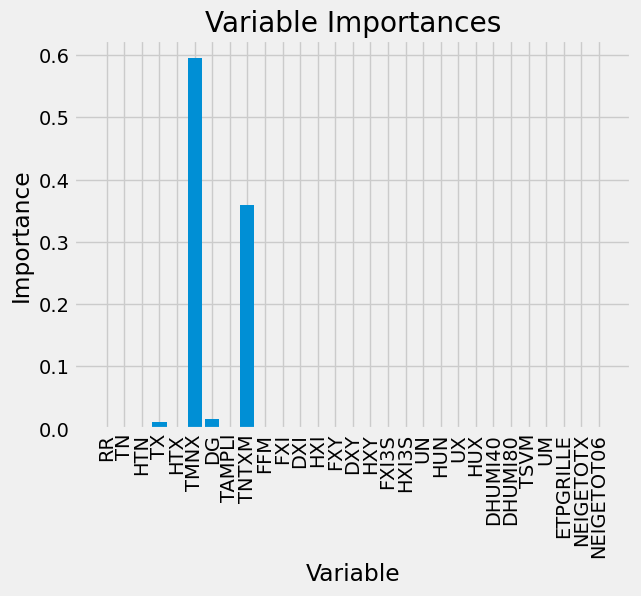

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

importances = list(rf.feature_importances_)
feature_list = list(x_train.columns)

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# mettre signification
On voit que la variable les plus importantes  sont  TMNX et TNTXM. On voit que la moins importante est NEIGTOT06

In [8]:
import io
from sklearn.tree import export_graphviz
import graphviz
from six import StringIO  
import pydotplus

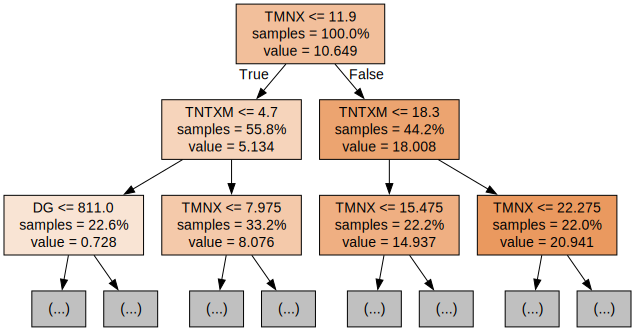

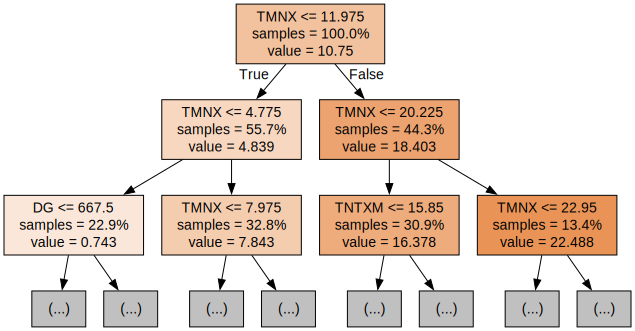

In [ ]:
#Visualisation des 2 premiers arbres
for i in range(2):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)





# Prévision

In [25]:
import numpy as np

predict=rf.predict(x_test)
# Calculate the absolute errors
errors = abs(predict - TM_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.64 degrees.


# Détermination des métriques de Performance

In [36]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_absolute_error


print('Mean Absolute Error:',mean_absolute_error(TM_test, predict))

mape = mean_absolute_percentage_error(TM_test, predict) * 100

# Calcul de R²
r2 = r2_score(TM_test, predict)

print(f"MAPE: {mape}%")
print(f"R²: {r2}")


Mean Absolute Error: 0.6369567341022249
MAPE: 5.066882085260647%
R²: 0.9720630241782955


In [49]:
# On ajoute les dates aux prédictions
predict_data= pd.DataFrame(data = {'date': TM_test.index, 'prediction': predict})
predict_data.head()

,date,prediction
0,2024-04-10,7.764341
1,2024-04-11,8.553876
2,2024-04-12,11.393411
3,2024-04-13,14.523256
4,2024-04-14,15.663566


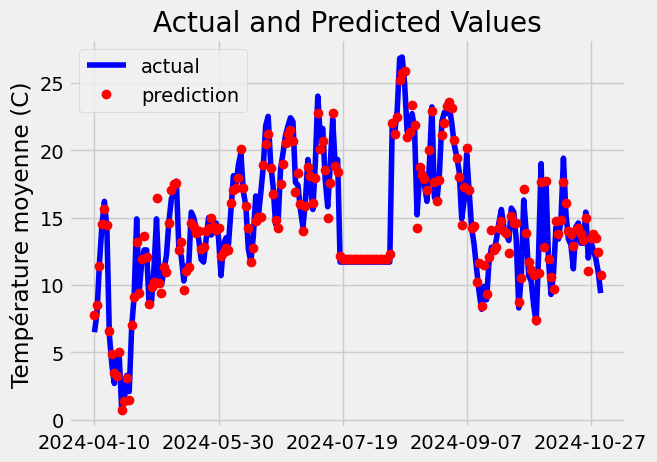

In [56]:
from matplotlib.ticker import MaxNLocator
#plot des vraies valeurs
#
plt.plot(TM_test.index, TM_test, 'b-', label = 'actual')


# Plot the predicted values
plt.plot(predict_data['date'], predict_data['prediction'], 'ro', label = 'prediction')
# Limiter le nombre de ticks à 5 maximum
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))
#plt.xticks(rotation="vertical") 
plt.legend()
# Graph labels
plt.ylabel('Température moyenne (C)'); plt.title('Actual and Predicted Values');


